## Exercises Part 1: FTP Optimisation

**Basic Selection**
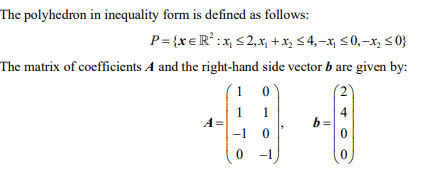
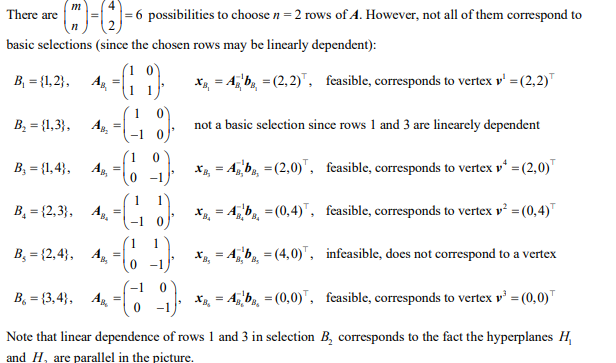$

In [2]:
import sympy as sp
from itertools import combinations
from IPython.display import display, Latex
#################### Define in here #############

# Corrected matrix A and vector b
A_corrected = sp.Matrix([[1,0], [1,1],[-1,0],[0,-1]])
b_corrected = sp.Matrix([2, 4, 0, 0])
n = 2 # Variables
k = 4 # Constraints  
# As array of indexes 0-end : i.e. row 2 and 4 = [1,3] else None
duplicate_rows = None
amount_duplicate = 0

############### Automatic##############

# Calculate the number of possible bases with and without duplicates

if amount_duplicate == 0:
    nCk_corrected = sp.binomial(k, n)
    display(Latex(r"There are: ${}$ possibilities to choose n ={} rows of $A$".format(nCk_corrected, n)))
    row_combinations = list(combinations(range(k), n))
    
else:
    nCk_corrected_duplicate = sp.binomial(k - amount_duplicate, n)
    display(Latex(r"There are: ${}$ possibilities to choose n ={} rows of $A$ with skipping duplicate rows {}".format(nCk_corrected_duplicate, n, duplicate_rows)))
    row_combinations = [comb for comb in combinations(range(k), n) if not any(dup in comb for dup in duplicate_rows)]

# Generate all combinations of selecting 3 rows out of 7, excluding combinations containing duplicates


# Recalculate the basic selection matrices excluding duplicates
matrices = [A_corrected[list(comb), :] for comb in row_combinations]
inv_matrices = []
for matrix in matrices:
    try:
        inv_matrices.append(matrix.inv())
    except:
        inv_matrices.append(None)

# Recalculate \boldsymbol{x}_{B} for each basic selection
x_B = []
for idx, comb in enumerate(row_combinations):
    if inv_matrices[idx] is not None:
        x_B.append(inv_matrices[idx] * b_corrected[list(comb), :])
    else:
        x_B.append(None)

# Prepare and display the basic selections in LaTeX with duplicate rows skipped
basic_selections_latex_skipping_duplicates = []
for idx, comb in enumerate(row_combinations):
    if x_B[idx] is not None:
        basic_selections_latex_skipping_duplicates.append(
            r' We have B=${}$: $A_B$ = {}, $x_B=A_B^{{-1}} b_B$ = {}'.format(
                ', '.join(map(str, [i+1 for i in comb])), 
                A_corrected[list(comb), :],
                x_B[idx]
            )
        )
    else:
        basic_selections_latex_skipping_duplicates.append(
            r' We have B=${}$: $A_B$ = {}, $x_B=A_B^{{-1}} b_B$ is not invertible'.format(
                ', '.join(map(str, [i+1 for i in comb])), 
                A_corrected[list(comb), :]
            )
        )

# Display the basic selections with duplicates skipped
for selection in basic_selections_latex_skipping_duplicates:
    display(Latex(selection))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

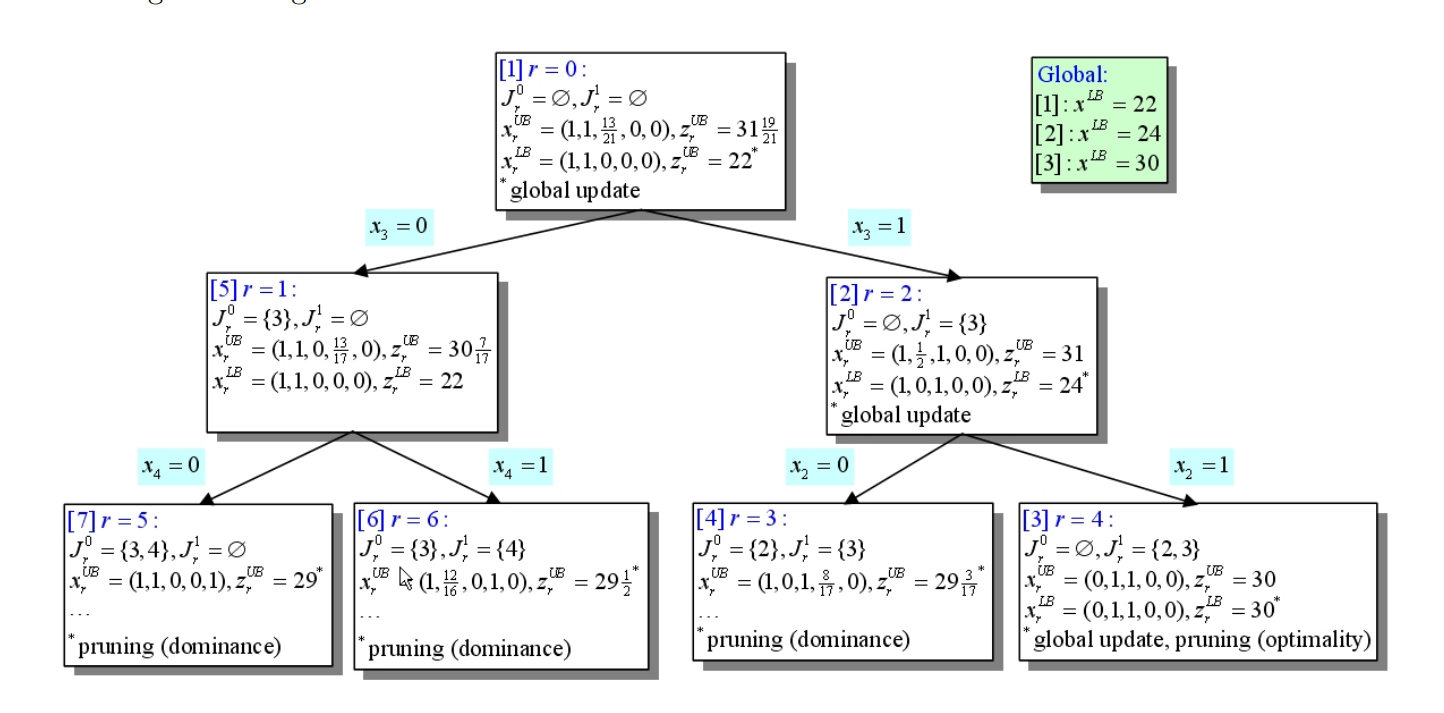

In [45]:
from IPython.display import display, Latex
def knapsack_branch_and_bound_improved(benefits, costs, budget):
    best_solution = None
    best_value = 0

    def lp_relaxation(benefits, costs, budget, excluded_items, included_items):

        infeasible = False 
        pruning = False
        optimality = False
      
        total_value = 0
        solution = [0] * len(benefits)
        weight_remaining = budget

        ## Adding the included items to the solution:
        for item in included_items:
            # Adds the benefit of all incldued items to the total value
            weight_remaining -= costs[item]
            total_value += benefits[item]
            solution[item] = 1
 
        if weight_remaining < 0:
            infeasible = True
            return None, None, None, None, None, True, None
        
        for j, cost in enumerate(costs):
            if j in excluded_items:
                solution[j] = 0
                continue
            if cost <= weight_remaining:
                if j not in included_items:
                    solution[j] = 1
                    weight_remaining -= costs[j]
                    total_value += benefits[j]
                    continue
            if j not in excluded_items and j not in included_items and weight_remaining > 0:
                # Adds fractional value of the item to the Knapsack
                solution[j] = weight_remaining / costs[j]
                total_value += solution[j] * benefits[j]
                break
        
        # Calculate the heuristic solution:
        heuristic_solution = None
        heuristic_value = None

        fractional_var = next((i for i, x in enumerate(solution) if isinstance(x, float) and not x.is_integer()), None)
        if fractional_var is None:
            heuristic_solution = solution
            heuristic_value = sum(heuristic_solution[j] * benefits[j] for j in range(len(benefits)))

        else:
            heuristic_solution = solution.copy()
            heuristic_solution[fractional_var] = 0
            heuristic_value = sum(heuristic_solution[j] * benefits[j] for j in range(len(benefits)))

        XUB = solution
        ZUB = total_value
        XLB = heuristic_solution
        ZLB = heuristic_value

        # Check for optimality lower bound = upper bound
        if ZLB == ZUB:
            optimality = True
            return XUB, ZUB, XLB, ZLB, infeasible, pruning, optimality

        # Check for possible pruning:
        if ZUB <= best_value:
            pruning = True
            return XUB, ZUB, XLB, ZLB, infeasible, pruning, optimality

        return  XUB, ZUB, XLB, ZLB, infeasible, pruning, optimality
    
    
    def branch_and_bound(node, benefits, costs, budget, exluded_items, included_items, iteration):
        nonlocal best_solution, best_value
        XUB, ZUB, XLB, ZLB, infeasible, pruning, optimality = lp_relaxation(benefits, costs, budget, exluded_items, included_items)
        
        if infeasible:
            print("Infeasible solution")
        else:
            print("--------------------------------------")
            display(Latex(r'Iteration: ${}$'.format(iteration)))
            # Add 1 to excluded items and included items for printing
            exluded_items_print = {i+1 for i in exluded_items}
            included_items_print = {i+1 for i in included_items}
            display(Latex(r'$J_r^0 ={}$'.format(exluded_items_print)))
            display(Latex(r'$J_r^1 ={}$'.format(included_items_print)))
            display(Latex(r'$x_r^{{U B}} ={}$'.format(XUB)))
            display(Latex(r'$z_r^{{U B}} ={}$'.format(ZUB)))
            display(Latex(r'$x_r^{{L B}} ={}$'.format(XLB)))
            display(Latex(r'$z_r^{{L B}} ={}$'.format(ZLB)))
            display(Latex(r'Pruning: ${}$'.format(pruning)))
            display(Latex(r'infeasible: ${}$'.format(infeasible)))
            print("--------------------------------------")

        
        # Keep info for the current node
        info[node] = [XUB, ZUB, XLB, ZLB, infeasible, pruning, optimality]

    
        if optimality:
            if ZLB > best_value:  # Update the best solution
                best_solution, best_value = XLB, ZLB
                print("New best solution found: {}".format(best_value))
            return

        # Find the first fractional variable
        fractional_var = None
        for i, x in enumerate(XUB):
            if isinstance(x, float):
                fractional_var = i
                break
        
        if not (pruning or infeasible):
            # Find the first fractional variable
            fractional_var = next((i for i, x in enumerate(XUB) if isinstance(x, float)), None)

            if fractional_var is not None:
                # Explore the right branch first (including the fractional item)
                new_included_items = included_items | {fractional_var}
                branch_and_bound(node * 2 + 1, benefits, costs, budget, exluded_items, new_included_items, iteration + 1)
                
                # Then explore the left branch (excluding the fractional item)
                new_excluded_items = exluded_items | {fractional_var}
                branch_and_bound(node * 2 + 2, benefits, costs, budget, new_excluded_items, included_items, iteration + 1)
    
    branch_and_bound(0, benefits, costs, budget, set(),set(), 0)

# Input here:
benefits = [11, 14, 16, 8, 7]  # Example benefits
costs = [17, 16, 21, 8, 12]    # Example costs
budget = 37  

# We start here by sortint the items by their benefit/cost ratio
# items = sorted((j for j in range(len(benefits))),
info = {}
items = sorted((j for j in range(len(benefits)) ), 
                       key=lambda j: -benefits[j]/costs[j])

# Sort benefits and costs based on the items
benefits = [benefits[j] for j in items]
costs = [costs[j] for j in items]

knapsack_branch_and_bound_improved(benefits, costs, budget)



--------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

--------------------------------------
--------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

--------------------------------------
--------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

--------------------------------------
New best solution found: 30
--------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

--------------------------------------
--------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

--------------------------------------
--------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

--------------------------------------
--------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

--------------------------------------


# Simplex:
